In [ ]:
# 구글 드라이브 마운트
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# 폴더 복사
import glob
import distutils.dir_util
source_path1 = '/content/drive/MyDrive/aihub/딥페이크 변조 영상/train_img/Fake_img/Fake_img1'
my_path1 = '/content/drive/MyDrive/deepfake/Fake_img'

distutils.dir_util.copy_tree(source_path1, my_path1)

print("파일이 성공적으로 복사되었습니다.")

fake = glob.glob('/content/drive/MyDrive/deepfake/Fake_img/*')
print(len(fake))

In [ ]:
source_path2 = '/content/drive/MyDrive/aihub/딥페이크 변조 영상/train_img/Real_img/Real_img1'
my_path2 = '/content/drive/MyDrive/deepfake/Real_img'

distutils.dir_util.copy_tree(source_path2, my_path2)

print("파일이 성공적으로 복사되었습니다.")

real = glob.glob('/content/drive/MyDrive/deepfake/Real_img/*')
print(len(real))

In [ ]:
# glob
import glob
real = glob.glob('/content/drive/MyDrive/resized_jj/Real_img1/*')
print(len(real))

fake = glob.glob('/content/drive/MyDrive/resized_jj/Fake_img1/*')
print(len(fake))

10000
10000


In [ ]:
# 경로 지정
# real = 0 / fake = 1
import os
data_path = '/content/drive/MyDrive/resized_jj/'
categories = os.listdir(data_path)
labels = [0,1]
label_dict = dict(zip(categories,labels))
print(label_dict)

{'Real_img1': 0, 'Fake_img1': 1}


In [ ]:
# 이미지 로드 및 라벨링
import cv2
import numpy as np
import random

data=[]
target=[]

num_samples_per_category = 1000

for category in categories:
  folder_path = os.path.join(data_path, category)
  img_names = os.listdir(folder_path)

  random.shuffle(img_names)  # 섞기
  img_names = img_names[:num_samples_per_category]  # 일부 선택

  for img_name in img_names:
    img_path = os.path.join(folder_path,img_name)
    img = cv2.imread(img_path)
    print(img_path)

    try:
      #gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
      #resized = cv2.resize(img,(224, 224))
      data.append(img)
      target.append(label_dict[category])
    except Exception as e:
            print(f"Error processing image: {img_path}, Error: {str(e)}")

In [ ]:
# 라벨링이 잘 되었는 지 확인
from collections import Counter
counter = Counter(target)
print(counter)

# 정규화
data=np.array(data)/255.0
target=np.array(target)

print(data.shape)
print(target.shape)

Counter({0: 1000, 1: 1000})
(2000, 224, 224, 3)
(2000,)


In [ ]:
# 학습셋, 검증셋, 테스트셋 분리
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=42)
#X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

# 모델 설계
# ResNet50 모델 기반
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import Conv2D
from keras.callbacks import ModelCheckpoint
from keras.callbacks import EarlyStopping
from tensorflow.python.keras.optimizer_v2 import rmsprop

base_model = ResNet50(weights='imagenet',
                      include_top=False, input_shape=(224,224,3))
model = Sequential()
model.add(base_model)
model.add(Conv2D(64, (3,3), activation='relu'))
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# 기반층 학습되지 않도록 설정 -> 차원 축소 및 오버피팅 방지
base_model.trainable = False

opt = keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


model.summary()

94765736/94765736 [==============================] - 4s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 conv2d (Conv2D)             (None, 5, 5, 64)          1179712   
                                                                 
 global_average_pooling2d (  (None, 64)                0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 256)               16640     
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               32

In [ ]:
# 옵션 지정
early_stopping = EarlyStopping(monitor='val_loss', patience=30, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    '/content/drive/MyDrive/deep_model/model_10000.hdf5',
    monitor='val_loss',
    verbose=0,
    save_best_only=True,
    mode='auto')

In [ ]:
# 모델 학습
history=model.fit(X_train, y_train,
                  epochs=1000,
                  batch_size=30,
                  callbacks=[checkpoint, early_stopping],
                  validation_data=(X_test, y_test))

In [ ]:
print(model.evaluate(X_test, y_test))

13/13 [==============================] - 5s 210ms/step - loss: 0.2721 - accuracy: 0.9075
[0.2720675766468048, 0.9075000286102295]


In [ ]:
# f1-score, 재현율, 정확도 확인
from sklearn.metrics import classification_report

y_pred = model.predict(X_test)
y_pred = (y_pred >= 0.5).astype(int)
print(classification_report(y_test, y_pred))

13/13 [==============================] - 2s 95ms/step
              precision    recall  f1-score   support

           0       0.95      0.86      0.90       199
           1       0.88      0.95      0.91       201

    accuracy                           0.91       400
   macro avg       0.91      0.91      0.91       400
weighted avg       0.91      0.91      0.91       400



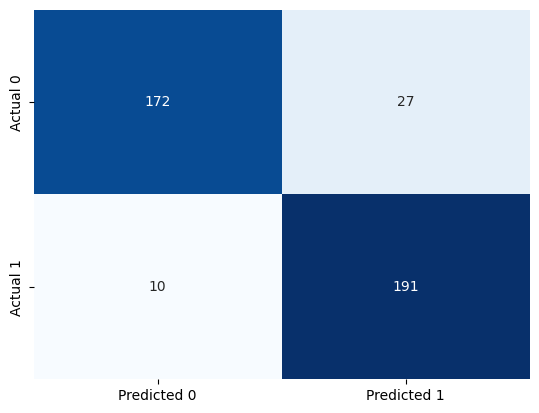

In [ ]:
# confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])

plt.show()

In [ ]:
from sklearn.metrics import f1_score, recall_score, accuracy_score

# f1, accuracy, recall 구하기
f1_score = f1_score(y_test, y_pred)
acc_score = accuracy_score(y_test, y_pred)
recall_score = recall_score(y_test, y_pred)

print("f1-score:")
print(f"{f1_score:0.5f}")

print("acc-score:")
print(f"{acc_score:0.5f}")

print("recall-score:")
print(f"{recall_score:0.5f}")

f1-score:
0.91169
acc-score:
0.90750
recall-score:
0.95025


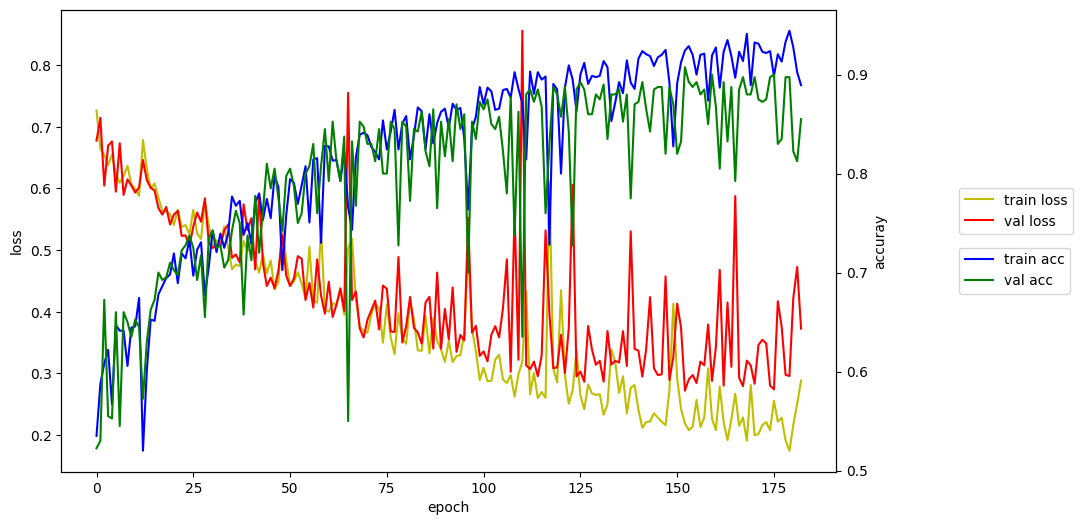

In [ ]:
import matplotlib.pyplot as plt

fig, loss_ax = plt.subplots(figsize=(10,6))
acc_ax = loss_ax.twinx()

acc_ax.plot(history.history['accuracy'], 'b', label='train acc')
acc_ax.plot(history.history['val_accuracy'], 'g', label='val acc')

loss_ax.plot(history.history['loss'], 'y', label='train loss')
loss_ax.plot(history.history['val_loss'], 'r', label='val loss')

loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuray')

acc_ax.legend(loc='upper left', bbox_to_anchor=(1.15, 0.5))
loss_ax.legend(loc='lower left', bbox_to_anchor=(1.15, 0.5))

plt.show()